<a href="https://colab.research.google.com/github/ArivalaganRaghavan/Computer-vision-practise/blob/main/CV_practice_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!gdown https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC

Downloading...
From (original): https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC
From (redirected): https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC&confirm=t&uuid=f4cb9619-3369-4016-a39c-2d27e7ec0aa5
To: /content/clothing-dataset-small.zip
100% 106M/106M [00:00<00:00, 318MB/s] 


In [12]:
!unzip /content/clothing-dataset-small.zip

Archive:  /content/clothing-dataset-small.zip
replace clothing-dataset-small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Import statement

In [31]:
import os
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(111)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
%matplotlib inline

In [32]:
def load_data(base_dir="clothing-dataset-small"):
    # checking if the data folders are present
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/validation") and os.path.exists(f"{base_dir}/test")

    print('\nLoading Data...')
    train_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/train", shuffle=True, label_mode='categorical'
    )
    val_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/validation", shuffle=False, label_mode='categorical'
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/test", shuffle=False, label_mode='categorical'
    )
    return train_data, val_data, test_data, train_data.class_names

In [33]:
train_data, val_data, test_data, class_names = load_data()


Loading Data...
Found 3068 files belonging to 10 classes.
Found 341 files belonging to 10 classes.
Found 372 files belonging to 10 classes.


### Data Preprocessing: Resizing, Standardization

In [34]:
def preprocess(train_data, val_data, test_data, target_height=128, target_width=128):

    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

## Model Architecture

In [36]:
def baseline(height=128, width = 128):
  num_classes= 10
  hidden_size = 256

  model = keras.Sequential(
      name = "model_cnn",
      layers = [
          layers.Conv2D(filters = 16, kernel_size=3, padding="same", activation = 'relu', input_shape=(height, width,3)),
          layers.MaxPooling2D(),
          layers.Flatten(),
          layers.Dense(units=hidden_size, activation = 'relu'),
          layers.Dense(units=num_classes, activation = 'softmax')
      ]
  )
  return model

In [37]:
model = baseline()
model.summary()

Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,780,490 (64.01 MB)

 Trainable params: 16,780,490 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

### Compile and train

In [41]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint.weights.h5"):
    epochs = 10
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [42]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 70s 696ms/step - accuracy: 0.2623 - loss: 3.7747 - val_accuracy: 0.4164 - val_loss: 1.8027
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 641ms/step - accuracy: 0.5557 - loss: 1.3801 - val_accuracy: 0.5191 - val_loss: 1.5348
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 628ms/step - accuracy: 0.7183 - loss: 0.9263 - val_accuracy: 0.5396 - val_loss: 1.4985
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 85s 668ms/step - accuracy: 0.8573 - loss: 0.5499 - val_accuracy: 0.5806 - val_loss: 1.5064
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 718ms/step - accuracy: 0.9227 - loss: 0.3232 - val_accuracy: 0.5836 - val_loss: 1.4995
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 713ms/step - accuracy: 0.9719 - loss: 0.1622 - val_accuracy: 0.6041 - val_loss: 1.5292
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 91s 807ms/step - accuracy: 0.9844 - loss: 0.0964 - val_accuracy: 0.6012 - val_loss: 1.7249
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 68s 657ms/step - accuracy: 0.9944 - loss: 0.0501 - val_accu

Plot Train and Validation Accuracy

In [43]:
# helper function to annotate maximum values in the plots
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

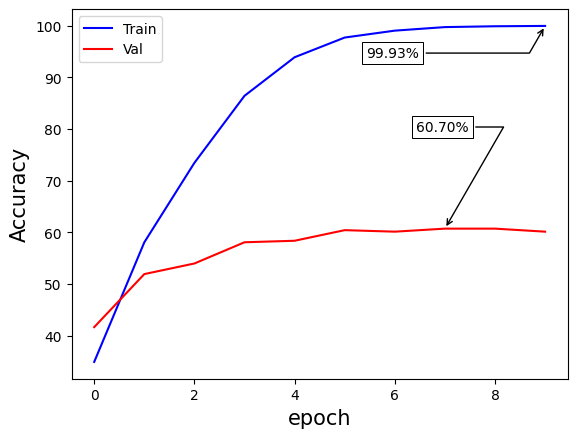

In [44]:
plot_accuracy(model_fit)

In [47]:
def print_accuracy_stats(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step

Test Accuracy: 52.96%

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


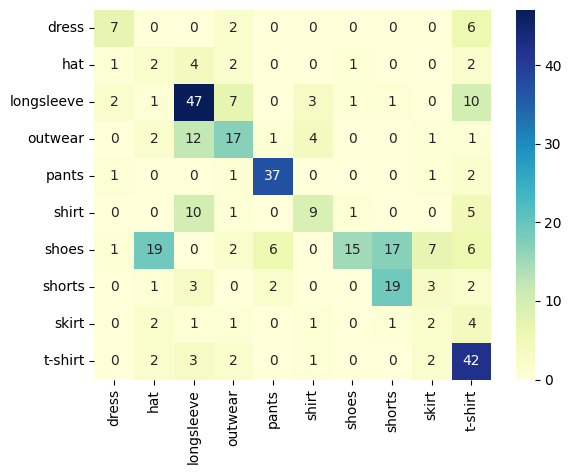

In [48]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

In [50]:
def arch_1(height=128, width = 128):
  num_classes = 10
  hidden_size = 256

  model = keras.Sequential(
      name = "model_cnn_1",
      layers = [
          layers.Conv2D(filters=16, kernel_size=3, padding = "same", activation='relu', input_shape=(height, width, 3)),
          layers.MaxPooling2D(),
          layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
          # layers.MaxPooling2D(),
          # layers.Flatten(),
          layers.GlobalAveragePooling2D(),
          layers.Dense(units=hidden_size, activation='relu'),
          layers.Dense(units=num_classes, activation='softmax')
      ]
  )
  return model


model = arch_1()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,970 (1.76 MB)

 Trainable params: 460,970 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
def compile_train_v1(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [53]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 791ms/step - accuracy: 0.6623 - loss: 1.0283 - val_accuracy: 0.5953 - val_loss: 1.1455
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 785ms/step - accuracy: 0.6954 - loss: 0.9100 - val_accuracy: 0.6100 - val_loss: 1.1216
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 789ms/step - accuracy: 0.6922 - loss: 0.9050 - val_accuracy: 0.6100 - val_loss: 1.1162
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.7305 - loss: 0.7936 - val_accuracy: 0.6100 - val_loss: 1.0644
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 125s 836ms/step - accuracy: 0.7379 - loss: 0.7670 - val_accuracy: 0.6129 - val_loss: 1.0559
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 767ms/step - accuracy: 0.7541 - loss: 0.7128 - val_accuracy: 0.6628 - val_loss: 0.9401
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 792ms/step - accuracy: 0.7707 - loss: 0.6691 - val_accuracy: 0.6510 - val_loss: 1.0363
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 789ms/step - accuracy: 0.7892 - loss: 0.5983 - val_accura

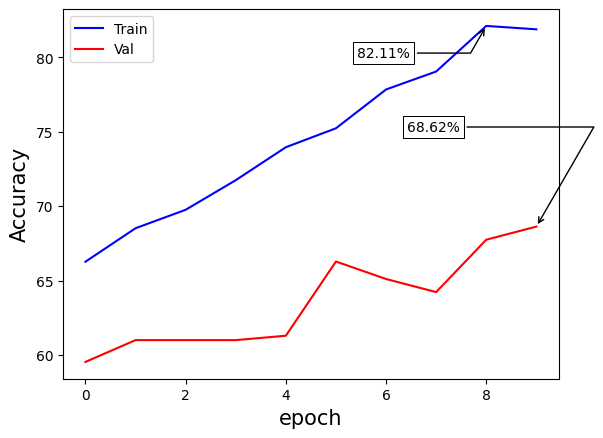

In [54]:
plot_accuracy(model_fit)

In [55]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 786ms/step - accuracy: 0.8362 - loss: 0.4734 - val_accuracy: 0.6716 - val_loss: 1.0195
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 790ms/step - accuracy: 0.8581 - loss: 0.4035 - val_accuracy: 0.6833 - val_loss: 1.1000
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 776ms/step - accuracy: 0.8717 - loss: 0.3834 - val_accuracy: 0.7067 - val_loss: 0.9667
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 803ms/step - accuracy: 0.8881 - loss: 0.3256 - val_accuracy: 0.6569 - val_loss: 1.1740
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 805ms/step - accuracy: 0.9012 - loss: 0.3194 - val_accuracy: 0.6891 - val_loss: 1.1293
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 792ms/step - accuracy: 0.9088 - loss: 0.2664 - val_accuracy: 0.7038 - val_loss: 1.3164
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 754ms/step - accuracy: 0.9108 - loss: 0.2729 - val_accuracy: 0.6686 - val_loss: 1.2147
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 84s 780ms/step - accuracy: 0.9105 - loss: 0.2399 - val_accu

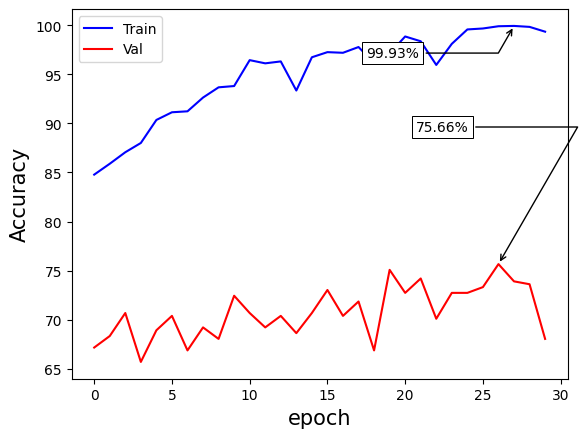

In [57]:
plot_accuracy(model_fit)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step

Test Accuracy: 70.97%

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step


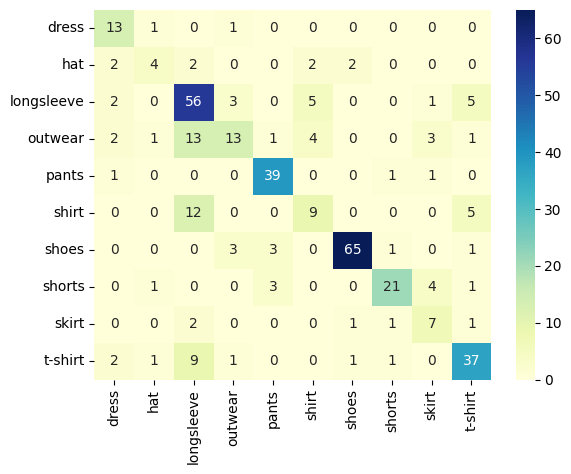

In [58]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

In [59]:
def arch_2(height=128, width=128):
    num_classes = 10
    hidden_size = 256
    model = keras.Sequential(
        name="model_cnn_2",
        layers = [
            layers.Conv2D(filters=16, kernel_size = 3, padding = "same", input_shape = (height, width, 3)),
            layers.Activation('relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # Layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [60]:
model = arch_2()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             

 Total params: 463,978 (1.77 MB)

 Trainable params: 462,474 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [61]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.2104 - loss: 2.8650 - val_accuracy: 0.2375 - val_loss: 3.8784
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.3474 - loss: 2.2181 - val_accuracy: 0.2375 - val_loss: 3.4023
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3937 - loss: 1.9936 - val_accuracy: 0.2375 - val_loss: 4.9239
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.4727 - loss: 1.6852 - val_accuracy: 0.2962 - val_loss: 2.9247
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.5268 - loss: 1.4739 - val_accuracy: 0.4223 - val_loss: 1.8793
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5796 - loss: 1.3208 - val_accuracy: 0.5132 - val_loss: 1.4758
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6369 - loss: 1.1009 - val_accuracy: 0.4575 - val_loss: 1.5020
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6878 - loss: 0.9746 - val_accuracy: 0.6393 - v

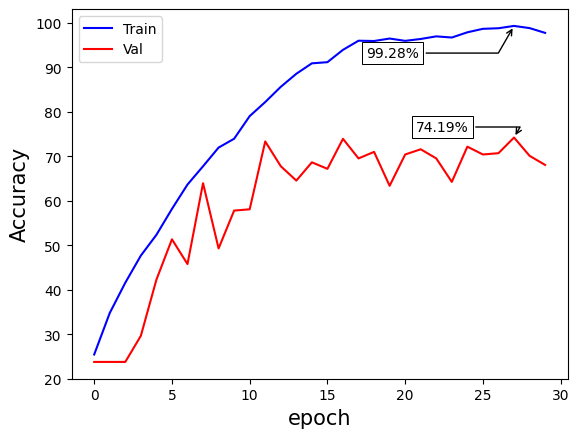

In [62]:
plot_accuracy(model_fit)


### **Modification #3**

#### 1. Use `ReduceLROnPlateau` as LR Scheduler and `EarlyStopping` to stop training once the loss curve plateaus.

In [63]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path= "/tmp/checkpoint.weights.h5"):
  callbacks = [
      keras.callbacks.ReduceLROnPlateau(
          monitor = "val_loss", factor=0.3, patience=2, min_lr = 0.00001
      ),
      keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor = 'val_accuracy', mode = 'max', save_best_only=True),
      keras.callbacks.EarlyStopping(
          monitor = "val_loss", patience=10, min_delta=0.001, mode='min'
      )
  ]
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  model_fit=model.fit(train_ds, validation_data = val_ds, epochs = epochs, callbacks = callbacks)
  return model_fit

In [64]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.2175 - loss: 2.9109 - val_accuracy: 0.2287 - val_loss: 2.2965 - learning_rate: 0.0010
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.3120 - loss: 2.3036 - val_accuracy: 0.2375 - val_loss: 2.8069 - learning_rate: 0.0010
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.3997 - loss: 1.9829 - val_accuracy: 0.3050 - val_loss: 2.3850 - learning_rate: 0.0010
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.4779 - loss: 1.6847 - val_accuracy: 0.3930 - val_loss: 1.9463 - learning_rate: 3.0000e-04
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.5357 - loss: 1.4749 - val_accuracy: 0.4370 - val_loss: 1.7098 - learning_rate: 3.0000e-04
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5516 - loss: 1.3464 - val_accuracy: 0.4868 - val_loss: 1.5197 - learning_rate: 3.0000e-04
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6012 - loss: 1.2320 - 

KeyboardInterrupt: 

In [ ]:
plot_accuracy(model_fit)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

In [ ]:
def arch_3(height=128, width=128):
    num_classes = 10
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model


model = arch_3()
model.summary()

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

In [ ]:
plot_accuracy(model_fit)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)